In [88]:
# Import Library
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
import h5py
from tensorflow.keras import layers
from matplotlib.pyplot import imshow

%matplotlib inline

Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are the same or 
different. We are going to implement both of them: the "identity block" and the "convolutional block."

#Identity block
---(SKIP CONNECTION from)-->conv2D, BATCHNORM, RELU--> CONV2D, BATCHNORM---> CONV2D, BATCHNORM---(SKIP CONNECTION to)--> RELU

In [89]:
def identity_block(X, f, filters, training= True, initializer=tf.keras.initializers.random_uniform):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    F1,F2,F3= filters # retrieve filters
    X_shortcut=X  # Save the input value. You'll need this later to add back to the main path. 
    
    #first component of main path
    X=tf.keras.layers.Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding="valid", kernel_initializer=initializer(seed=0))(X)
    X=tf.keras.layers.BatchNormalization(axis=3)(X, training=training)#If training is set to False, its weights are not updated with the new examples. I.e when the model is used in prediction mode.
    X=tf.keras.layers.Activation('relu')(X)
    
     #second component of main path
    X= tf.keras.layers.Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1),  padding='same', kernel_initializer=initializer(seed=0))(X)     
    X= tf.keras.layers.BatchNormalization(axis=3)(X, training=training) 
    X= tf.keras.layers.Activation('relu')(X)
    
    #third component of main path
    X= tf.keras.layers.Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X= tf.keras.layers.BatchNormalization(axis=3)(X, training=training)
      
    #Final step
    X=tf.keras.layers.Add()([X, X_shortcut])
    X=tf.keras.layers.Activation('relu')(X)
    
    return X
        

#convolutional block:
We can use this type of block when the input and output dimensions don't match up. 
The difference with the identity block is that there is a CONV2D layer in the shortcut path: 



In [90]:
def convolutional_block(X, f, filters, s=2, training=True, initializer= tf.keras.initializers.glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    F1,F2,F3=filters    # Retrieve Filters
    X_shortcut=X        # Save the input value
    
    
    #first component of main path 
    X=tf.keras.layers.Conv2D(filters=F1, kernel_size=(1,1),strides=(s,s), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X=tf.keras.layers.BatchNormalization(axis=3)(X,training=training)
    X=tf.keras.layers.Activation('relu')(X)
    
    #second block
    
    X=tf.keras.layers.Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', kernel_initializer=initializer(seed=0))(X)
    X=tf.keras.layers.BatchNormalization(axis=3)(X, training=training)
    X=tf.keras.layers.Activation('relu')(X)
    
    #third block
    X=tf.keras.layers.Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding ='valid',kernel_initializer=initializer(seed=0))(X)
    X=tf.keras.layers.BatchNormalization(axis=3)(X, training=training)
    
    #shortcut path
    X_shortcut= tf.keras.layers.Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s),padding='valid',kernel_initializer=initializer(seed=0))(X_shortcut)
    X_shortcut=tf.keras.layers.BatchNormalization(axis=3)(X_shortcut,training=training)
    
    #Final step
    X= tf.keras.layers.Add()([X, X_shortcut])
    X= tf.keras.layers.Activation('relu')(X)
    
    return X


# Building ResNet Model (50 layers)
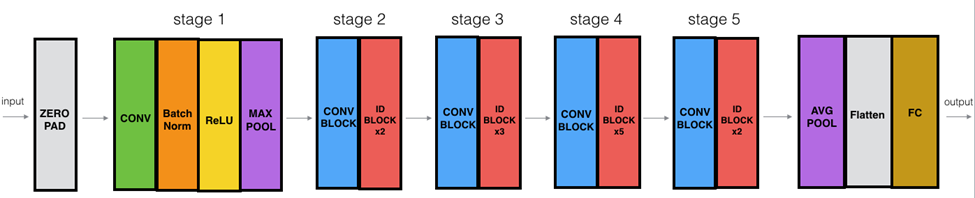





In [91]:
def ResNet50(input_shape=(64,64,3),classes=6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input=tf.keras.Input(shape=input_shape)
    
    X=tf.keras.layers.ZeroPadding2D(padding=(3,3))(X_input)
    
    #stage1:
    X=tf.keras.layers.Conv2D(filters=64, kernel_size=(7,7), strides=(2,2), kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0))(X)
    X=tf.keras.layers.BatchNormalization(axis=3)(X) # why dint we include training=True?
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))(X)
    
    #stage 2:
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
    #stage 3:
    X= convolutional_block(X,f=3, filters=[128,128,512], s=2)
    X= identity_block(X, f=3, filters=[128,128,512])
    X= identity_block(X, f=3, filters=[128,128,512])
    X= identity_block(X, f=3, filters=[128,128,512])
    
    #stage 4:
    X= convolutional_block(X, f=3, filters=[256, 256, 1024], s=2)
    X= identity_block(X, f=3, filters=[256, 256, 1024])
    X= identity_block(X, f=3, filters=[256, 256, 1024])
    X= identity_block(X, f=3, filters=[256, 256, 1024])
    X= identity_block(X, f=3, filters=[256, 256, 1024])
    X= identity_block(X, f=3, filters=[256, 256, 1024])
    
    #stage 5:
    X= convolutional_block(X, f=3, filters=[512,512,2048], s=2)
    X= identity_block(X, f=3, filters=[512,512,2048])
    X= identity_block(X, f=3, filters=[512,512,2048]) 
    
    X=tf.keras.layers.AveragePooling2D(pool_size=(2,2))(X)
    X=tf.keras.layers.Flatten()(X)
    X=tf.keras.layers.Dense(units=classes, activation='softmax', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0))(X)
    
    #create model
    model=tf.keras.models.Model(inputs=X_input, outputs=X)
    
    return model

In [92]:
model=ResNet50(input_shape=(64,64,3), classes=6)
print(model.summary())

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d_27 (ZeroPadding  (None, 70, 70, 3)   0           ['input_29[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv2d_685 (Conv2D)            (None, 32, 32, 64)   9472        ['zero_padding2d_27[0][0]']      
                                                                                                  
 batch_normalization_679 (Batch  (None, 32, 32, 64)  256         ['conv2d_685[0][0]']       

 activation_627 (Activation)    (None, 15, 15, 64)   0           ['batch_normalization_688[0][0]']
                                                                                                  
 conv2d_695 (Conv2D)            (None, 15, 15, 256)  16640       ['activation_627[0][0]']         
                                                                                                  
 batch_normalization_689 (Batch  (None, 15, 15, 256)  1024       ['conv2d_695[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_194 (Add)                  (None, 15, 15, 256)  0           ['batch_normalization_689[0][0]',
                                                                  'activation_625[0][0]']         
                                                                                                  
 activatio

                                                                                                  
 add_197 (Add)                  (None, 8, 8, 512)    0           ['batch_normalization_699[0][0]',
                                                                  'activation_634[0][0]']         
                                                                                                  
 activation_637 (Activation)    (None, 8, 8, 512)    0           ['add_197[0][0]']                
                                                                                                  
 conv2d_706 (Conv2D)            (None, 8, 8, 128)    65664       ['activation_637[0][0]']         
                                                                                                  
 batch_normalization_700 (Batch  (None, 8, 8, 128)   512         ['conv2d_706[0][0]']             
 Normalization)                                                                                   
          

 conv2d_716 (Conv2D)            (None, 4, 4, 256)    262400      ['activation_646[0][0]']         
                                                                                                  
 batch_normalization_710 (Batch  (None, 4, 4, 256)   1024        ['conv2d_716[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_647 (Activation)    (None, 4, 4, 256)    0           ['batch_normalization_710[0][0]']
                                                                                                  
 conv2d_717 (Conv2D)            (None, 4, 4, 256)    590080      ['activation_647[0][0]']         
                                                                                                  
 batch_normalization_711 (Batch  (None, 4, 4, 256)   1024        ['conv2d_717[0][0]']             
 Normaliza

                                                                                                  
 activation_657 (Activation)    (None, 4, 4, 256)    0           ['batch_normalization_720[0][0]']
                                                                                                  
 conv2d_727 (Conv2D)            (None, 4, 4, 1024)   263168      ['activation_657[0][0]']         
                                                                                                  
 batch_normalization_721 (Batch  (None, 4, 4, 1024)  4096        ['conv2d_727[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_204 (Add)                  (None, 4, 4, 1024)   0           ['batch_normalization_721[0][0]',
                                                                  'activation_655[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 add_207 (Add)                  (None, 2, 2, 2048)   0           ['batch_normalization_731[0][0]',
                                                                  'activation_664[0][0]']         
                                                                                                  
 activation_667 (Activation)    (None, 2, 2, 2048)   0           ['add_207[0][0]']                
                                                                                                  
 average_pooling2d_11 (AverageP  (None, 1, 1, 2048)  0           ['activation_667[0][0]']         
 ooling2D)                                                                                        
                                                                                                  
 flatten_1

In [93]:
#compile the model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [113]:
#load the hand sign dataset
import numpy as np
train_dataset=h5py.File(r'C:\Users\tempt\Desktop\deeplearning_ai\COURSE4_W2\W2A1\datasets\train_signs.h5','r')  # train_dataset.keys() contains --> ['list_classes', 'train_set_x', 'train_set_y']>
X_train_orig=np.array(train_dataset['train_set_x'])# shape --> (1080, 64, 64, 3)
Y_train_orig=np.array(train_dataset['train_set_y'])# shape --> (1080,)

test_dataset=h5py.File(r'C:\Users\tempt\Desktop\deeplearning_ai\COURSE4_W2\W2A1\datasets\test_signs.h5','r')
X_test_orig=np.array(test_dataset['test_set_x'])# shape--> (120, 64, 64, 3)
Y_test_orig=np.array(test_dataset['test_set_y'])  # shape--> (120,)

classes=np.array(test_dataset['list_classes'])# 6 classes -->array([0, 1, 2, 3, 4, 5], dtype=int64)

#reshape
Y_train_orig=Y_train_orig.reshape(1,Y_train_orig.shape[0]) # file.reshape(())/ file.reshape()--> both works
Y_test_orig=Y_test_orig.reshape(1,Y_test_orig.shape[0])


In [204]:
#Normalize image vectors
X_train=X_train_orig/255.
X_test=X_test_orig/255.

# convert training & test set Y lables to one hot matrices
Y_train=(np.eye(6)[Y_train_orig.reshape(-1)].T).T
Y_test=(np.eye(6)[Y_test_orig.reshape(-1)].T).T

#Y_train=np.eye(6)[Y_train_orig.reshape(-1)]
#Y_test=np.eye(6)[Y_test_orig.reshape(-1)]

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


[0. 0. 0. 0. 0. 1.]
[0 1 2 3 4 5]


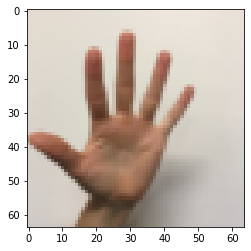

In [205]:
print(Y_train[3])
print(classes)
imshow(X_train[3,:,:,:])

In [146]:
model.fit(x=X_train, y=Y_train, batch_size=32, epochs=4)
#stopped after 4 epochs 

Epoch 1/10
34/34 [==============================] - 88s 2s/step - loss: 1.5533 - accuracy: 0.4944
Epoch 2/10
34/34 [==============================] - 88s 3s/step - loss: 0.7208 - accuracy: 0.7917
Epoch 3/10
34/34 [==============================] - 83s 2s/step - loss: 0.4868 - accuracy: 0.8426
Epoch 4/10
28/34 [=======================>......] - ETA: 16s - loss: 0.3902 - accuracy: 0.8739

KeyboardInterrupt: 

In [147]:
preds=model.evaluate(X_test, Y_test)
print("Loss="+str(preds[0]))
print("Test accuracy = "+str(preds[1]))

4/4 [==============================] - 6s 424ms/step - loss: 0.7225 - accuracy: 0.8000
Loss=0.7224849462509155
Test accuracy = 0.800000011920929


In [206]:
pretrained_model=tf.keras.models.load_model(r'C:\Users\tempt\Desktop\deeplearning\resnet50.h5')

In [207]:
preds=pretrained_model.evaluate(X_test, Y_test)
print("Loss = "+str(preds[0]))
print("Test accuracy = "+str(preds[1]))

4/4 [==============================] - 2s 260ms/step - loss: 0.1596 - accuracy: 0.9500
Loss = 0.15958665311336517
Test accuracy = 0.949999988079071


Input image shape: (1, 64, 64, 3)
Class: 4


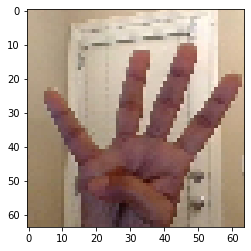

In [212]:
img_path='C:/Users/tempt/Desktop/deeplearning/4.jpg'
img=tf.keras.preprocessing.image.load_img(img_path, target_size=(64,64))
x=tf.keras.preprocessing.image.img_to_array(img)
x=np.expand_dims(x,axis=0) # converts (64,64,3) into--> (1,64,64,3)
x=x/255.0
print('Input image shape:', x.shape)
imshow(img)
prediction=pretrained_model.predict(x)
#print(" Class prediction vector [p(0),p(1),p(2),p(3),p(4),p(5)]= ",prediction)
print("Class:", np.argmax(prediction))